In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import itertools as it

from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import pearsonr

# Load in Materials From `make.images.ipynb`

In [2]:
prefix = '/data/xyzeq/xyzeq/'

In [3]:
adata = sc.read_h5ad(prefix + 'concatenated.deep/deep2/adata.xy.h5ad')

/home/ssm-user/anaconda3/envs/xyzeq/lib/python3.6/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/home/ssm-user/anaconda3/envs/xyzeq/lib/python3.6/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [7]:
adata.obs['Y'].value_counts()

10    2771
11    2594
12    2426
9     2291
13    2103
16    2032
15    1977
14    1848
8     1693
17    1671
7     1469
5     1424
6     1307
4     1223
3      904
18     880
2      706
1      286
Name: Y, dtype: int64

In [4]:
myhex = np.zeros((12,12))
myhex[0:1,3:9] = 1
myhex[1:3,2:10] = 1
myhex[3:5,1:11] = 1
myhex[5:7,:12] = 1
myhex[7:9,1:11] = 1
myhex[9:11,2:10] = 1
myhex[11:12,3:9] = 1

In [5]:
hex_coords = pd.read_pickle('/data/xyzeq/xyzeq/concatenated.deep/deep2/hex.coords.pkl')
counts = pd.read_pickle('/data/xyzeq/xyzeq/concatenated.deep/deep2/counts.celltype1.pkl')
# counts = pd.read_pickle('/data/xyzeq/xyzeq/concatenated.deep/deep2/counts.celltype2.pkl')

In [6]:
def get_colors(df, cts, color=True, prop_den=None, clip_vals=None):
    '''
    This function takes in the counts of each cell type from the DataFrame and 
    will generate color values based on the proportion of cells in each well
    that are the celltype(s) of interest. If color set to False, will just
    return the actual proportion of each cell type not scaled to RGB values.
    
    cts is a list of celltypes.
    
    For calculating proportion, will use a denomintaor of the total of only the provided 
    cell types (prop_den='cts') or the total of all cells (prop_den='tot'). If not
    provided, for len(ct) == 1 will set to 'tot', else will use 'cts'.
    
    Counts will be floored to zero for number of cells below clip_val before taking
    the proportion. len(clip_val)
    
    Plotting raw counts is kind of unmeaningful, so skipping that for now.
    '''
    assert type(cts) == type(list())
    
    if type(clip_vals) == type(None):
        clip_vals = [0]*len(cts)
    else:
        assert len(clip_vals) == len(cts)

    if type(prop_den) == type(None):
        # will fill in with what I think is appropriate if not provided
        if len(cts) == 1:
            prop_den = 'tot'
        else:
            prop_den = 'cts'
            
    # actually get the denominator
    if prop_den == 'cts':
        prop_den_vals = df[cts].sum(axis=1).values
    elif prop_den == 'tot':
        prop_den_vals = df.sum(axis=1).values
    else:
        raise ValueError
    
    val_dict = dict() 
    val_arrs = [np.zeros((len(df),))]*3 
    
    for i in range(len(cts)):
        ct = cts[i]
        val_dict[ct] = df[ct].values
        clip_val = clip_vals[i]
        val_dict[ct] = np.where(val_dict[ct] < clip_val, 0, val_dict[ct])
        with np.errstate(invalid='ignore'):
            val_dict[ct] = val_dict[ct] / prop_den_vals # this produces Nans, but they get replaced with 0 when converting to np.uint8
        val_arrs[i] = val_dict[ct]
        
    if color == True:
        colors = [255*i for i in val_arrs]
        colors = np.stack(colors, axis=1).astype(np.uint8)
        val_df = pd.DataFrame(colors,index=df.index,columns=['r','g','b'])
    else:
        props = np.nan_to_num(np.stack(val_arrs[:len(cts)], axis=1))
        val_df = pd.DataFrame(props, index=df.index, columns=['%' + '%s/%s' % (ct, prop_den) for ct in cts])
                              
#     val_df = val_df[val_df.sum(axis=1) != 0] # do not include this, just fill the whole thing, I thought to include it to reduce time but it causes problems later

    return val_df

In [7]:
def get_image(color_df):
    '''
    color_df is a dataframe with columns 'r', 'g', and 'b', corresponding to the color values
    that should be filled into each hexagon.
    '''
    img = list()
    for color in ['r','g','b']:
        hex_array = np.zeros((222,399))
        for y, x in it.product(range(1,19),range(1,45)):

            try:
                val = color_df.loc[(x, y), color]
            except: # I should make this exception more specific
                continue

            xstart = hex_coords.loc[(x,y),'hex_xstart']
            ystart = hex_coords.loc[(x,y),'hex_ystart']

            yend = hex_coords.loc[(x,y),'hex_yend']
            xend = hex_coords.loc[(x,y),'hex_xend']

            current_hex = hex_array[ystart:yend,xstart:xend]
            hex_array[ystart:yend,xstart:xend] = np.where(myhex, val, current_hex)
        img.append(hex_array)
    img = np.stack(img, axis=2).astype(np.uint8)
    return img

In [8]:
img_list = list()
for batch in tqdm(counts.index.get_level_values('batch').unique()):
    images = list()
    color_df = get_colors(counts.loc[batch], cts=['Hepato', 'MC38'])
    img = get_image(color_df)
    img_list.append(img)

### Analysis 1: Spatial Dependence

I want to show the spatial dependence of the wells: those that are immediate neighbors are likely to contain similar number of hepatocytes/MC38.

In [11]:
segment = counts[['Hepato','MC38']].copy()

In [12]:
segment['Tot'] = segment[['Hepato','MC38']].sum(axis=1)

In [13]:
with np.errstate(invalid='ignore'):
    segment['%Hepato'] = (segment['Hepato'] / segment['Tot']).fillna(0)
    segment['%MC38'] = (segment['MC38'] / segment['Tot']).fillna(0)
segment.drop(['Hepato','MC38'],axis=1, inplace=True)

Here I'm going to generate a new dataframe with data about the neighbors of each well from each batch. Doing the first analysis, I would like to correlate the percentage hepatocyte in each well with the mean percentage hepatocyte of its immediate neighbors. Many of the wells should be filtered (e.g. do they have at least 2 cells, are their neighbors not all zeros, how many cells do their neighbors have?). I think instead of filtering for this data as I record, I'll just collect all this data and filter afterwards.

In [14]:
# doing percent hepato

# do not use dict(zip(range(1,11),[list()]*10)) to initialize a list of dicts, it produces the same list object as the value to each key: https://stackoverflow.com/questions/11509721/how-do-i-initialize-a-dictionary-of-empty-lists-in-python
# after 2 years I'm still learning how python works
neighbor_data = pd.DataFrame(0, index=pd.MultiIndex.from_product([range(4),
                                                               range(1,43), 
                                                               range(1,19),
                                                               range(1,11)], names=['batch','X','Y','layer']),
                             columns=['Num Cells','%Hepato'])

In [ ]:
tots = list()
pheps = list()
for i in tqdm(segment.index):
    for layer in range(1, 11):

        # define useful variables
        batch = i[0]
        seg_idxs = list()
        
        for n_i in hex_coords.loc[(i[1], i[2]), 'neighbors_%s' % layer]: # for the n_i = index of each neighbor
            seg_idx = tuple(np.append(batch, n_i))
            seg_idxs.append(seg_idx)
            
        # subset the segment dataframe
        segment_sub = segment.loc[seg_idxs]
        tots.append(segment_sub['Tot'].values)
        pheps.append(segment_sub['%Hepato'].values)

In [ ]:
neighbor_data['Num Cells'] = tots

In [ ]:
neighbor_data['%Hepato'] = pheps

In [16]:
# neighbor_data.to_pickle(prefix + 'concatenated.deep/deep2/neighbor.data.pkl')
neighbor_data = pd.read_pickle(prefix + 'concatenated.deep/deep2/neighbor.data.pkl')

Okay, going to weight the means and variances by the number of cells observed in the well. Inavlid value in double_scalars just produces some NaNs, which I will address.

In [17]:
n_means = list()
n_vars = list()

for i, j in tqdm(zip(neighbor_data.values[:,0], neighbor_data.values[:,1]),total=len(neighbor_data)):
    weighted_stats = DescrStatsW(data=j, weights=i)
    n_means.append(weighted_stats.mean)
    n_vars.append(weighted_stats.std)

/home/ssm-user/anaconda3/envs/xyzeq/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:133: RuntimeWarning: invalid value encountered in double_scalars
  return self.sum / self.sum_weights


In [18]:
neighbor_data['n_means'] = n_means
neighbor_data['n_vars'] = n_vars

Visualize the variance as a function of the mean:

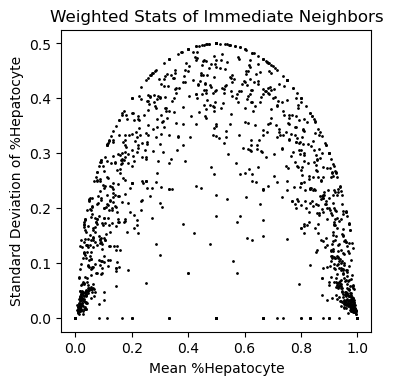

In [19]:
plt.figure(figsize=(4,4),dpi=100)
plt.scatter(neighbor_data[neighbor_data.index.get_level_values('layer') == 1]['n_means'].values,
            neighbor_data[neighbor_data.index.get_level_values('layer') == 1]['n_vars'].values, s=1, c='k');
plt.title('Weighted Stats of Immediate Neighbors')
plt.xlabel('Mean %Hepatocyte')
plt.ylabel('Standard Deviation of %Hepatocyte');

Variance is high when the mean is at 50% and low when the mean is at either end of the spectrum. This shows that our hepatocytes and our mc38 are well segregated -- our wells aren't all a mix of hepatocyte and cancer but rather many cancer only and many hepatocyte only wells.

In [20]:
well = segment['%Hepato'].values
mask_well = (well != 0) & (well != 1) # Looking only at mixed wells

In [21]:
n1_means = neighbor_data.loc[neighbor_data.index.get_level_values('layer') == 1,'n_means'].values
n1_vars = neighbor_data.loc[neighbor_data.index.get_level_values('layer') == 1,'n_vars'].values

mask_n1 = np.nan_to_num(n1_means, nan=-1) != -1 # means and vars have the same boolean mask

In [22]:
mask = mask_well & mask_n1

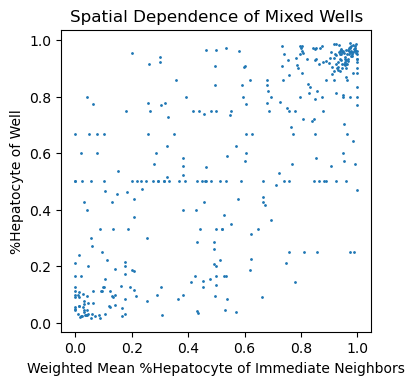

In [23]:
plt.figure(figsize=(4,4),dpi=100)
plt.scatter(x = n1_means[mask], y = well[mask], s=1);
ax = plt.gca()
ax.grid(False)
ax.set_xlabel('Weighted Mean %Hepatocyte of Immediate Neighbors')
ax.set_ylabel('%Hepatocyte of Well');
ax.set_title('Spatial Dependence of Mixed Wells');

In [24]:
pearsonr(x = n1_means[mask], y = well[mask])

(0.7404674689659052, 7.192168699048056e-67)

I'd like to show that the number of wells with high variance increases towards the center of the distribution (at around 50%).

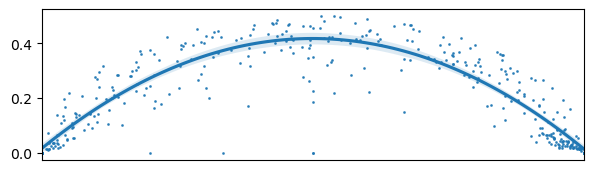

In [25]:
fig, ax = plt.subplots(figsize=(7,2), dpi=100)
sns.regplot(x=n1_means[mask], y=n1_vars[mask],
            scatter_kws={"s": 1},
            order=2, ci=99, truncate=True, ax=ax);
ax.xaxis.set_visible(False)

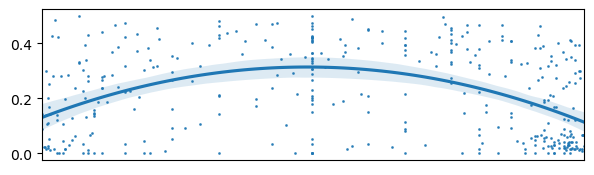

In [26]:
fig, ax = plt.subplots(figsize=(7,2), dpi=100)
sns.regplot(x=well[mask],
            y=n1_vars[mask],
            scatter_kws={"s": 1},
            order=2, ci=99, truncate=True, ax=ax);
ax.xaxis.set_visible(False)

### Analysis 2: Segmentation Score

The idea here is to use the neighbors to "score" each well as being towards the center of the hepatocyte region or MC38 region. We are curious to see on the UMAP whether or not cells deep in either Hepatocyte or MC38 regions are clustering out separately. 

The first low bar validation of this would be to just show that there is some polarity in UMAP space of the cells when just colored by percent Hepato/MC38. 

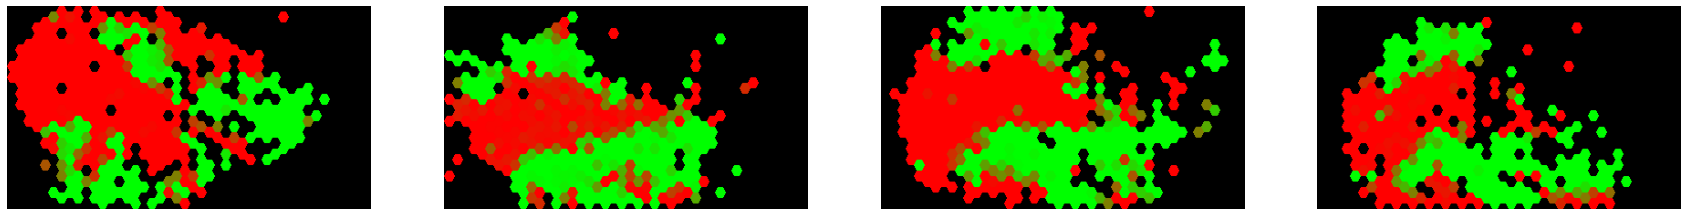

In [27]:
fig, axes = plt.subplots(1,4, figsize=(30,10))
for img, ax in zip(img_list, np.ravel(axes)):
    ax.imshow(img);
    ax.axis('off')

As shown above, many of the wells are either very high or very low percent hepatocyte (and vice versa for MC38), so coloring by this metric would give somewhat of a binary polarity. If that shows something significant in UMAP space, then we can try to parse out internal distance within each region. 

Thinking up a good distance metric is actually more difficult than I originally thought it would be. After thinking about this multiple times, I've narrowed it down to 2 ways to determine the metric:
1. Just take the mean % Hepato of all neighbors of order _n_ or lower (i.e. neighbors_1, neighbors_2, ... neighbors\__n_), or perhaps weighted by the order (so like neighbors_1 are weighted more highly than neighbors_4).
2. Base it (somehow) on the average distance of the 3 closest wells of the opposite color (green or red). Only using the distance to the closest green one would be a metric easily skewed by outlier wells (e.g. one green well in a sea a of red). Using 3 or 5 would help smooth out those outliers.

Here, will only focus on method 1, but we can try method 2 later on.

#### Low Bar Validation

In [28]:
index_obs = adata.obs[['batch','X','Y']]

In [30]:
pHepato = list()
for seg_index in tqdm(map(tuple, index_obs.values),total=len(index_obs)):
    # I only want to keep wells that have at least one hepatocyte or MC38
    no_cells = np.array([0.0,0.0])
    if np.all(segment.loc[seg_index,['%Hepato','%MC38']] == no_cells): # marking wells with 0 hepatocyte or MC38 to remove them later
        pHepato.append(-1)
    else:
        pHepato.append(segment.loc[seg_index,'%Hepato'])

In [31]:
adata.obs['%Hepato'] = pHepato

In [32]:
adata.shape

(29605, 20332)

In [33]:
adata[adata.obs['%Hepato'] != -1].shape

(28592, 20332)

In [34]:
adata_t = adata[adata.obs['%Hepato'] != -1].copy() # adata consisting of cells only on the "tissue" defined as having cells from either cancer or hepatocytes

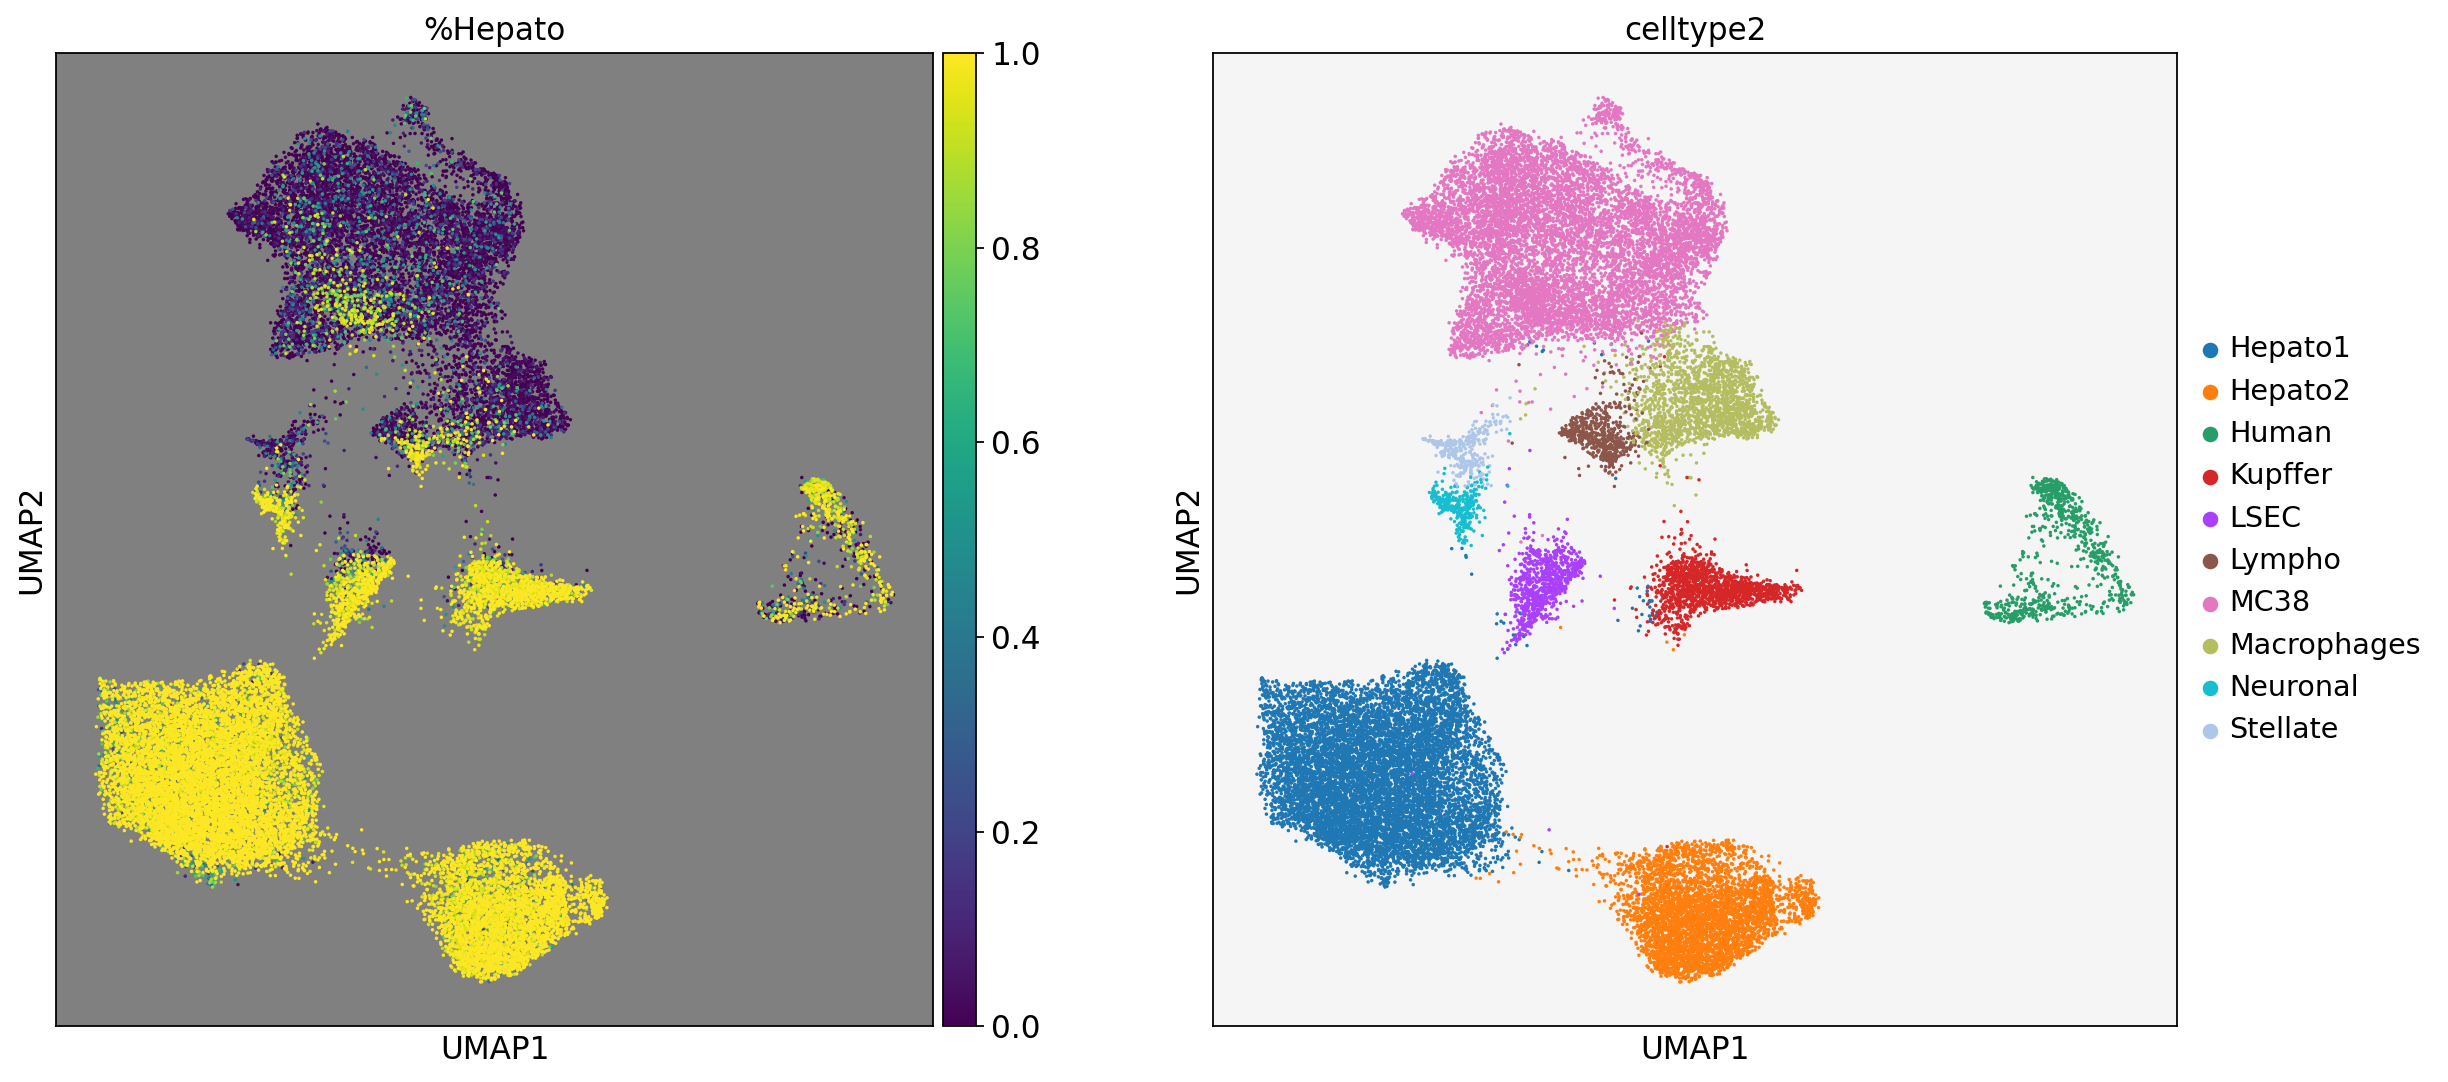

In [35]:
sc.settings.set_figure_params(dpi=80)
fig, ax = plt.subplots(1,2,figsize=(17,8))
ax[0].set_facecolor('gray')
ax[1].set_facecolor('whitesmoke')
sc.pl.umap(adata_t, color='%Hepato', ax=ax[0], size=10, show=False,return_fig=False);
sc.pl.umap(adata_t, color='celltype2', ax=ax[1], size=10, show=False,return_fig=False);

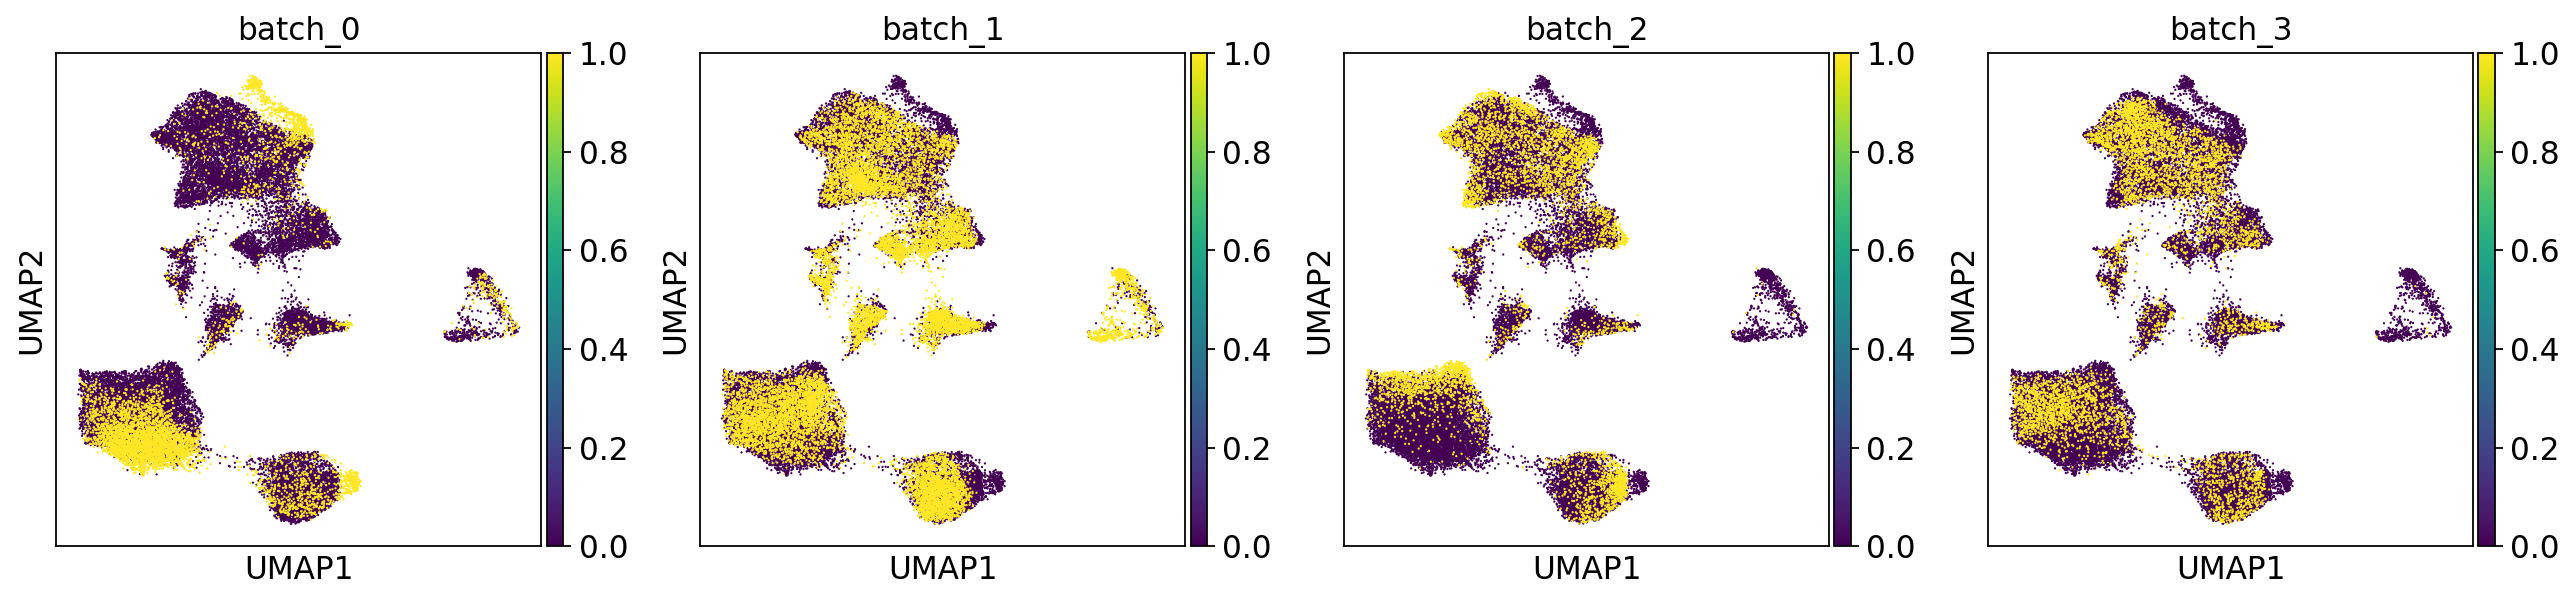

In [36]:
batches = adata_t.obs['batch'].unique() # get a list of the batches

# make a new column in the `.obs` for each batch that is of dtype `int` so that it gets plotted as a continuous variable instead of a categorical one
for batch in batches:
    adata_t.obs['batch_%s' % batch] = (adata_t.obs['batch'] == batch).astype(int)
sc.pl.umap(adata_t, color=['batch_%s' % i for i in batches],sort_order=True, ncols=4)

#### Method 1
So I'd like to come up with a score using the average %hepatocyte for each neighborhood of wells. There are many aspects of a well that I think should factor into its score:

1. The number of cells and the % hepatocyte in the well.
2. The number of cells and the % hepatocyte of neighboring wells.
3. The distance of neighboring wells from the well in question.

With this in mind, I think a dual weighting, of both number of cells and distance of neighbors from well, will produce some high-confidence, robust scores. I propose two possible solutions:
1. Take the cell-number-weighted mean %hepatocyte of the wells from successive layers of neighbors, and then take a distance-weighted mean of those means to produce a final score. 
2. Take an unweighted mean %hepatocyte and mean cell number of the wells from successive layers of neighbors, and then take a distance-weighted and mean-cell-number-weighted mean of those means to produce a final score. 

Method 1 does not factor in the number of cells in the well in question, so it may still be susceptile to outlier wells (i.e. 2 green cells in a well surrounded by tens of hepatocyte cells in all neighboring wells). Method 2 is a bit more convoluted, and may penalize wells on the edge of the tissue (i.e. a red well in border a bunch of other red wells but also the vast empty wells not in the tissue). I will try method 1 for now, and can explore method 2 later.

To determine the distance weights, I've proposed this systematic way that uses some factor to determine the decay of each successive layer of neighbors from the original well in question. `layers` is the number of layers of neighbors from the original well to consider for the calculation, and the `factor` controls the rate of decay and therefore the final weight. I've included the `repeat_1` parameter so that the first and second weights will be equal (which I think would make sense for the value of the well itself vs the value of the mean of all its immediate neighbors). 

In [39]:
def weight_decay(layers, factor, repeat_1=True):
    unnorm_weights = list(map(lambda x: 1/(factor**x), range(1,layers+1)))
    if repeat_1 == True:
        unnorm_weights = [unnorm_weights[0]] + unnorm_weights
    norm_weights = [i/sum(unnorm_weights) for i in unnorm_weights]
    return norm_weights

The function is based on infinite series of 1/2 + 1/4 + 1/8 + ..., where the factor is 2. That series converges to 1. However, in order to make the sum of weights add to 1 when terminated to a finite value, they end up being slightly off, as can be noted using `layers = 5`:

In [35]:
weight_decay(5, 2, repeat_1=False)

[0.5161290322580645,
 0.25806451612903225,
 0.12903225806451613,
 0.06451612903225806,
 0.03225806451612903]

Factor of 2 seems to be a bit too large, since it would give the last layer very little weight. I think I'll play with it so that it gives some qualitative good scores. 

In [36]:
weight_decay(5, 1.2, repeat_1=True)

[0.21792500420380023,
 0.21792500420380023,
 0.18160417016983352,
 0.1513368084748613,
 0.1261140070623844,
 0.10509500588532035]

In [37]:
nonzero = segment[segment[['%Hepato','%MC38']].sum(axis=1) != 0].copy()

In [38]:
dist_weights = weight_decay(5, 1.2, repeat_1=True)
scores = list()
for i in tqdm(nonzero.index):
    vals_list = [nonzero.loc[i,'%Hepato']]
    for layer in range(1,6):
        row = neighbor_data.loc[i].loc[layer]
        weighted_stats = DescrStatsW(data=row['%Hepato'], weights=row['Num Cells'])
        vals_list.append(weighted_stats.mean)
    weighted_stats = DescrStatsW(data=vals_list, weights=dist_weights)
    scores.append(weighted_stats.mean)

In [39]:
nonzero['score'] = scores

Some wells might have one entire layer with values of zero because they contained no cells. Because, weighting by an array of zeros yields `nan` from the weighted mean function, some wells will be `nan`.

In [40]:
sum(np.isnan(nonzero['score'].values))

28

For some good visualization, I'm going to color by the same colors as before, and also color low scores as green by using the difference of the score from the max per batch.

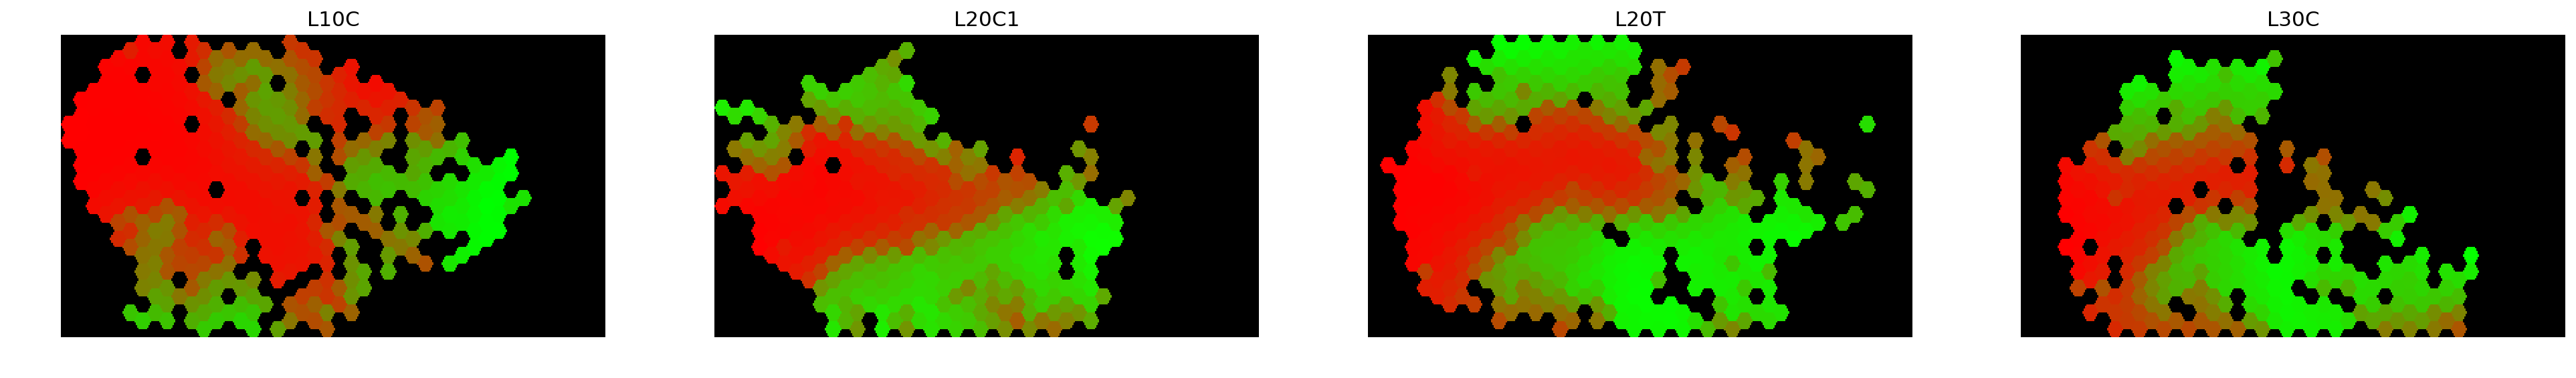

In [41]:
score_img_list = list()
for batch in tqdm(counts.index.get_level_values('batch').unique()):
    nonzero_batch = nonzero.loc[batch]
    max_score = nonzero_batch['score'].max(axis=0)
    color_df = pd.DataFrame(0, index = counts.loc[batch].index, columns = ['r','g','b'])
    for i in nonzero_batch.index:
        color_df.loc[i,'r'] = nonzero_batch.loc[i,'score']
        color_df.loc[i,'g'] = max_score - nonzero_batch.loc[i,'score']
    color_df['r'] = np.uint8(color_df['r']/color_df['r'].max()*255)
    color_df['g'] = np.uint8(color_df['g']/color_df['g'].max()*255)
    img = get_image(color_df)
    score_img_list.append(img)
fig, axes = plt.subplots(1,4, figsize=(30,10))
for img, ax, title in zip(score_img_list, np.ravel(axes), ['L10C', 'L20C1', 'L20T', 'L30C']):
    ax.imshow(img);
    ax.set_title(title)
    ax.axis('off')

/home/ghartoularos/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ghartoularos/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


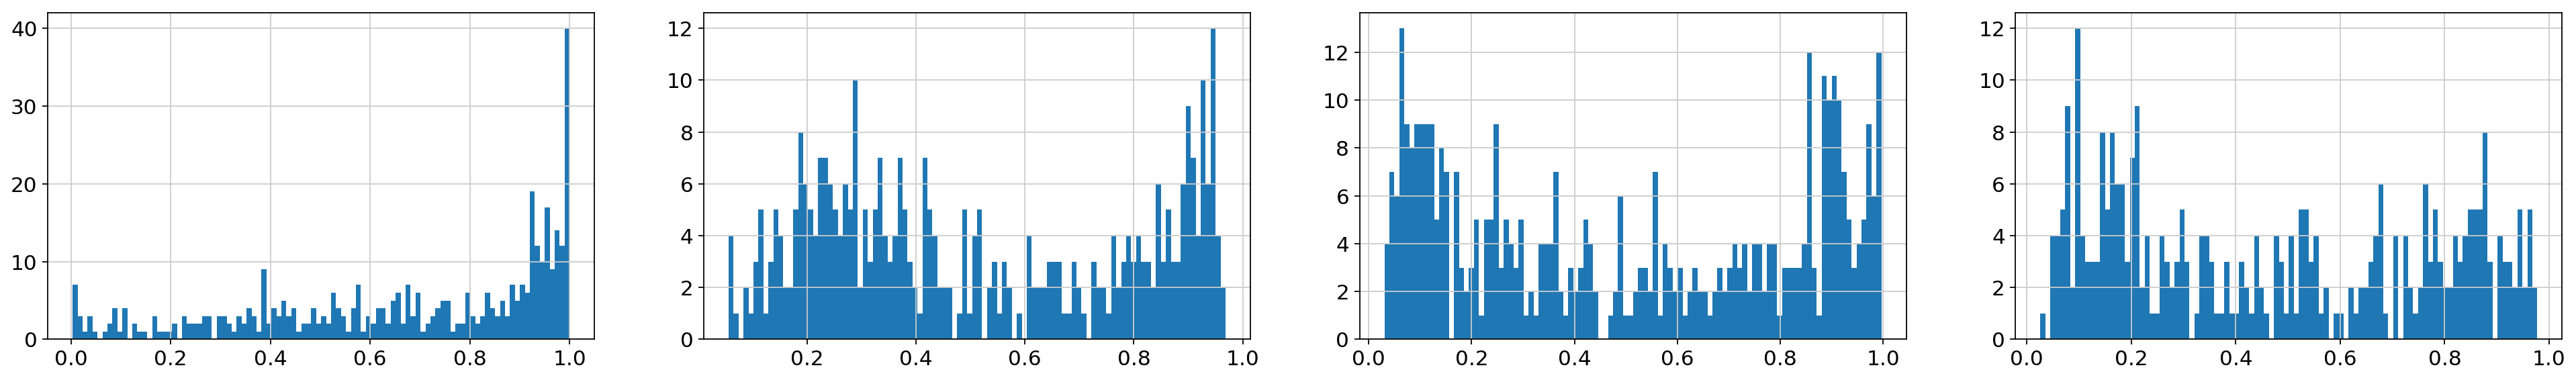

In [42]:
fig, axes = plt.subplots(1,4, figsize=(30,4))
for batch, ax in tqdm(zip(counts.index.get_level_values('batch').unique(), axes)):
    nonzero_batch = nonzero.loc[batch]
    ax.hist(nonzero_batch['score'].values,bins=100)

Cool, that doesn't look too bad! Compare the the original. 

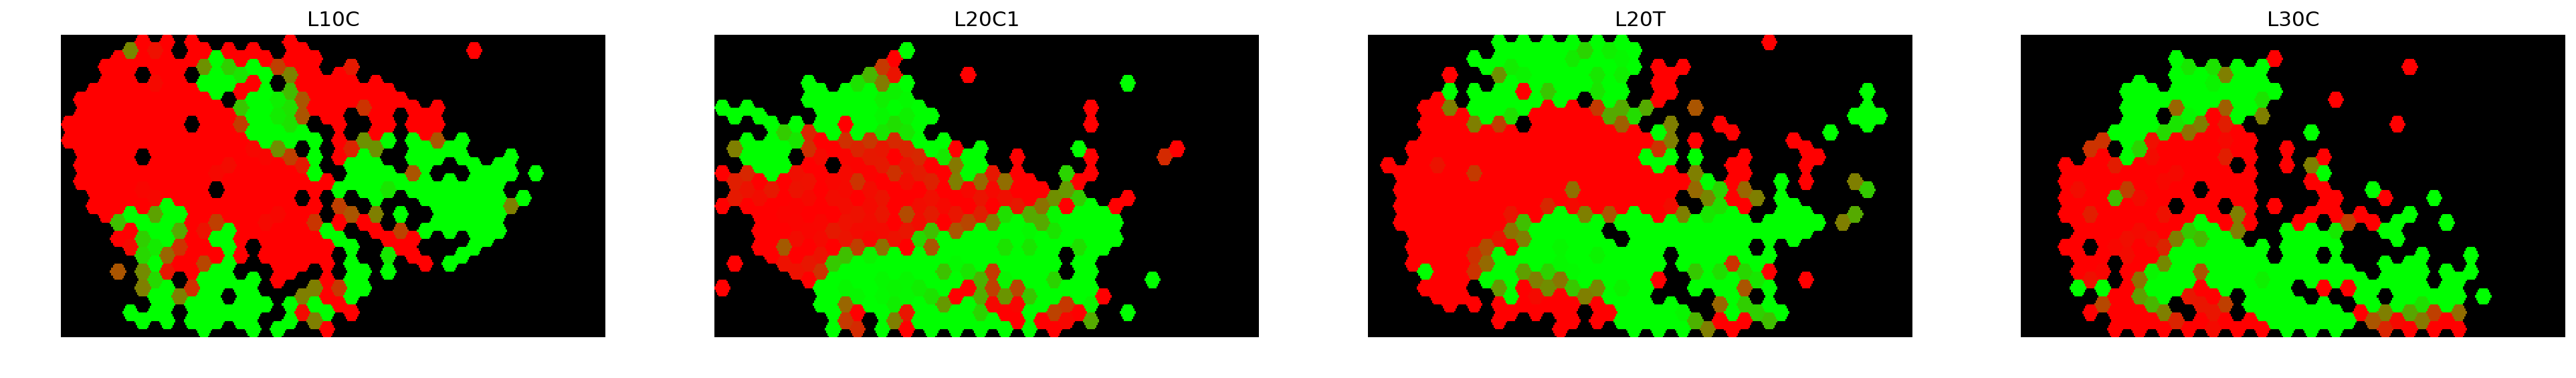

In [43]:
fig, axes = plt.subplots(1,4, figsize=(30,10))
for img, ax, title in zip(img_list, np.ravel(axes), ['L10C', 'L20C1', 'L20T', 'L30C']):
    ax.imshow(img);
    ax.set_title(title)
    ax.axis('off')

Note that the wells that became `nan`s were actually the ones that were either completely separated from the main tissue or were somewhete for away. This is kind of a nice unintended feature, checking if a well has all zero-valued neighbors in one layer is somewhat a measure of connectedness to the rest of the tissue. After seeing these, I realize what I'm doing is just blending the wells together at the borders. I'm going to put all of it in a function and play with some of the parameters.

In [37]:
def score_wells(segment, layers, factor, repeat_1_bool=True):
    nonzero = segment[segment[['%Hepato','%MC38']].sum(axis=1) != 0].copy()
    dist_weights = weight_decay(layers, factor, repeat_1=repeat_1_bool)
    print(dist_weights)
    ans = input('Continue?')
    if ans != 'y':
        return
    scores = list()
    print('Calculating scores.')
    for i in nonzero.index:
        if repeat_1_bool == True:
            vals_list = [nonzero.loc[i,'%Hepato']]
        else:
            vals_list = list()
        for layer in range(1,layers + 1):
            row = neighbor_data.loc[i].loc[layer]
            weighted_stats = DescrStatsW(data=row['%Hepato'], weights=row['Num Cells'])
            vals_list.append(weighted_stats.mean)
        weighted_stats = DescrStatsW(data=vals_list, weights=dist_weights)
        scores.append(weighted_stats.mean)
        
    nonzero['score'] = scores
    
    score_img_list = list()
    print('Building images.')
    for batch in counts.index.get_level_values('batch').unique():
        nonzero_batch = nonzero.loc[batch]
        max_score = nonzero_batch['score'].max(axis=0)
        color_df = pd.DataFrame(0, index = counts.loc[batch].index, columns = ['r','g','b'])
        for i in nonzero_batch.index:
            color_df.loc[i,'r'] = nonzero_batch.loc[i,'score']
            color_df.loc[i,'g'] = max_score - nonzero_batch.loc[i,'score']
        color_df['r'] = np.uint8(color_df['r']/color_df['r'].max()*255)
        color_df['g'] = np.uint8(color_df['g']/color_df['g'].max()*255)
        img = get_image(color_df)
        score_img_list.append(img)
    
    print('Plotting.')
    fig, axes = plt.subplots(1,4, figsize=(30,10))
    for img, ax, title in zip(score_img_list, np.ravel(axes), ['L10C', 'L20C1', 'L20T', 'L30C']):
        ax.imshow(img);
        ax.set_title(title)
        ax.axis('off')
    fig, axes = plt.subplots(1,4, figsize=(30,10))
    for img, ax, title in zip(img_list, np.ravel(axes), ['L10C', 'L20C1', 'L20T', 'L30C']):
        ax.imshow(img);
        ax.set_title(title)
        ax.axis('off')
    fig, axes = plt.subplots(1,4, figsize=(30,4))
    for batch, ax in tqdm(zip(counts.index.get_level_values('batch').unique(), axes)):
        nonzero_batch = nonzero.loc[batch]
        ax.hist(nonzero_batch['score'].values,bins=100)
    return nonzero

In [ ]:
nonzero = score_wells(segment, 5, 1.2)

**Update 20FEB20:** Derek asked for "smoother" scores (less binary looking?) for the continuous variable in the spatial differential expression analyses he's doing. Experimenting below.

In [ ]:
nonzero = score_wells(segment, 5, 1.1)

[0.10979573773102953, 0.10979573773102953, 0.10456736926764718, 0.09958797073109255, 0.09484568641056432, 0.09032922515291839, 0.08602783347896989, 0.08193126997997133, 0.07802978093330602, 0.07431407707933907, 0.07077531150413244]


Continue? y


Calculating scores.


/home/ssm-user/anaconda3/envs/xyzeq/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:133: RuntimeWarning: invalid value encountered in double_scalars
  return self.sum / self.sum_weights


Building images.
Plotting.


/home/ssm-user/anaconda3/envs/xyzeq/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ssm-user/anaconda3/envs/xyzeq/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


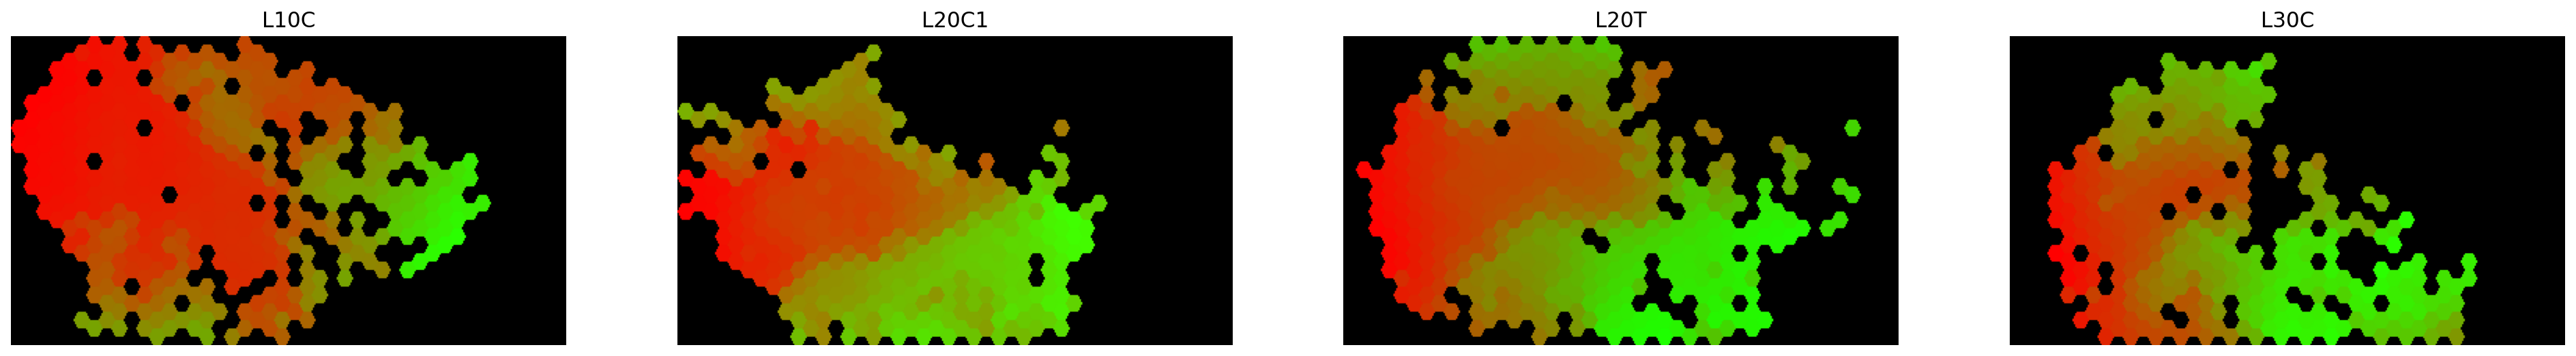

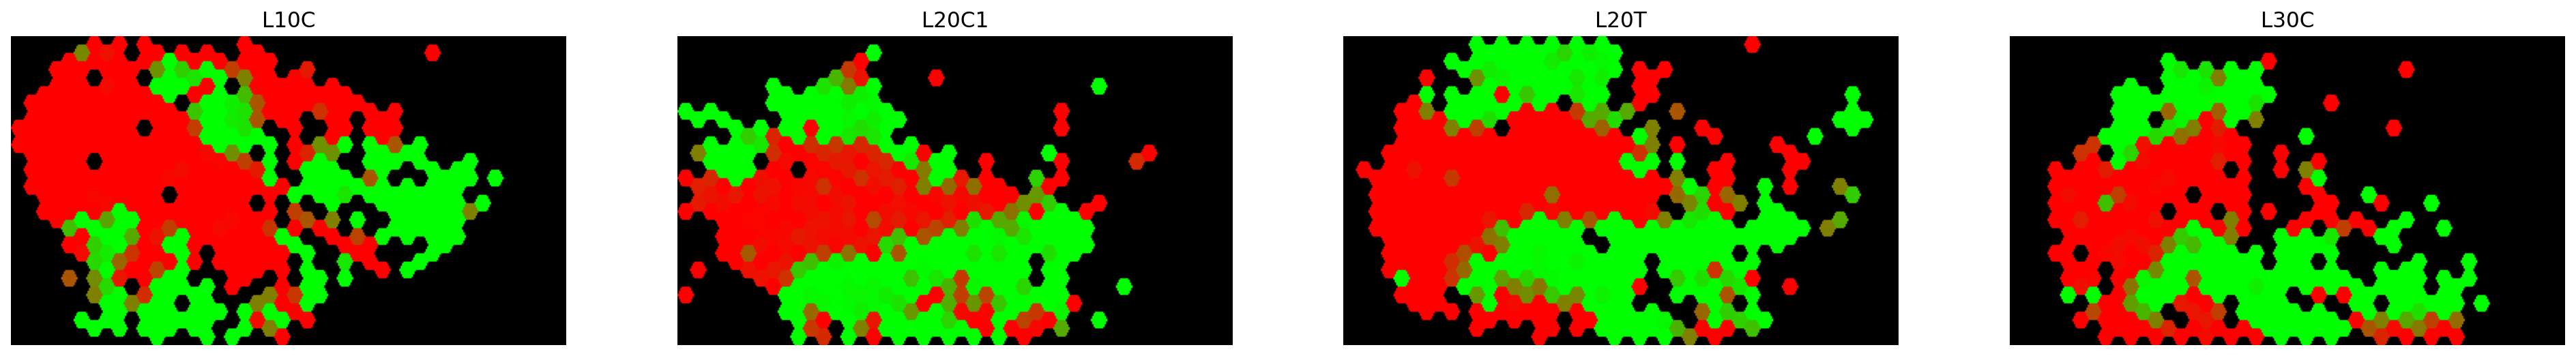

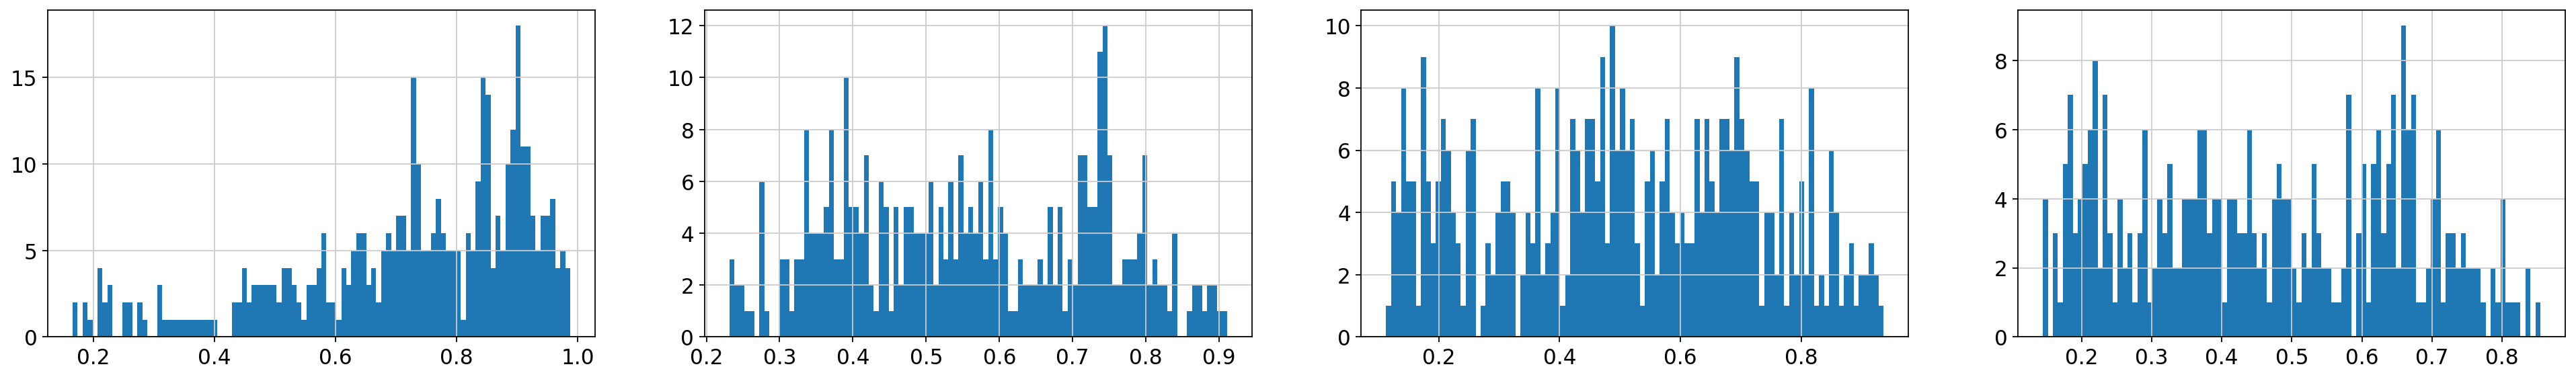

In [40]:
nonzero = score_wells(segment, 10, 1.05)

**14OCT20**: Build separate images for youjin.

In [ ]:
batch = 1

for layers, factor in zip([5, 10], [1.2, 1.05]):
    nonzero = score_wells(segment, layers, factor)
    nonzero_batch = nonzero.loc[batch]
    max_score = nonzero_batch['score'].max(axis=0)
    color_df = pd.DataFrame(0, index = counts.loc[batch].index, columns = ['r','g','b'])
    for i in nonzero_batch.index:
        color_df.loc[i,'r'] = nonzero_batch.loc[i,'score']
        color_df.loc[i,'g'] = max_score - nonzero_batch.loc[i,'score']
    color_df['r'] = np.uint8(color_df['r']/color_df['r'].max()*255)
    color_df['g'] = np.uint8(color_df['g']/color_df['g'].max()*255)
    img = get_image(color_df)

    fig, ax = plt.subplots(1,1, figsize=(10,5))
    ax.imshow(img);
    ax.set_title('L20C1')
    ax.axis('off')
    plt.savefig('/data/xyzeq/figures/10X.down.XYZ.decontam/gh.for.youjin.14OCT20/distance_metric/L20C1.metric.layers%d.decay%s.hexmap.svg' % (layers, str(factor))
    plt.close()
    
    fig, ax = plt.subplots(1,1, figsize=(8,5))
    nonzero_batch = nonzero.loc[batch]
    ax.hist(nonzero_batch['score'].values,bins=100);
    ax.set_xlim((0,1));
    ax.set_ylabel('Density of wells')
    ax.set_xlabel('Score');
    plt.savefig('/data/xyzeq/figures/10X.down.XYZ.decontam/gh.for.youjin.14OCT20/distance_metric/L20C1.metric.layers%d.decay%d.histogram.svg' % (layers, factor))
    plt.close()

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.imshow(img_list[batch]);
ax.set_title('L20C1')
ax.axis('off')
plt.savefig('/data/xyzeq/figures/10X.down.XYZ.decontam/gh.for.youjin.14OCT20/distance_metric/L20C1.no.metric.svg')
plt.close()

In [51]:
nonzero

Tot   %Hepato     %MC38     score
batch X  Y                                    
0     1  6     8  1.000000  0.000000  0.983078
         7    15  1.000000  0.000000  0.973708
      2  4     3  1.000000  0.000000  0.987515
         5    34  1.000000  0.000000  0.980727
         6    14  1.000000  0.000000  0.971808
...          ...       ...       ...       ...
3     36 17    7  0.571429  0.428571  0.377967
         18    1  1.000000  0.000000  0.431717
      37 14    2  0.000000  1.000000  0.186608
         15    1  0.000000  1.000000  0.204416
      38 16    1  0.000000  1.000000       NaN

[1535 rows x 4 columns]

In [53]:
nonzero_keep = nonzero[np.isnan(nonzero['score'].values) == False].copy()

# Color umap by score

In [54]:
scores = list()
for i in tqdm(adata.obs_names):
    nzk_index = tuple(adata.obs.loc[i, ['batch', 'X','Y']].values.astype(np.uint8))
    if nzk_index in nonzero_keep.index:
        scores.append(nonzero_keep.loc[nzk_index, 'score'])
    else:
        scores.append(-1)

In [55]:
adata.obs['score'] = scores

In [56]:
adata_keep = adata[adata.obs['score'] != -1].copy()

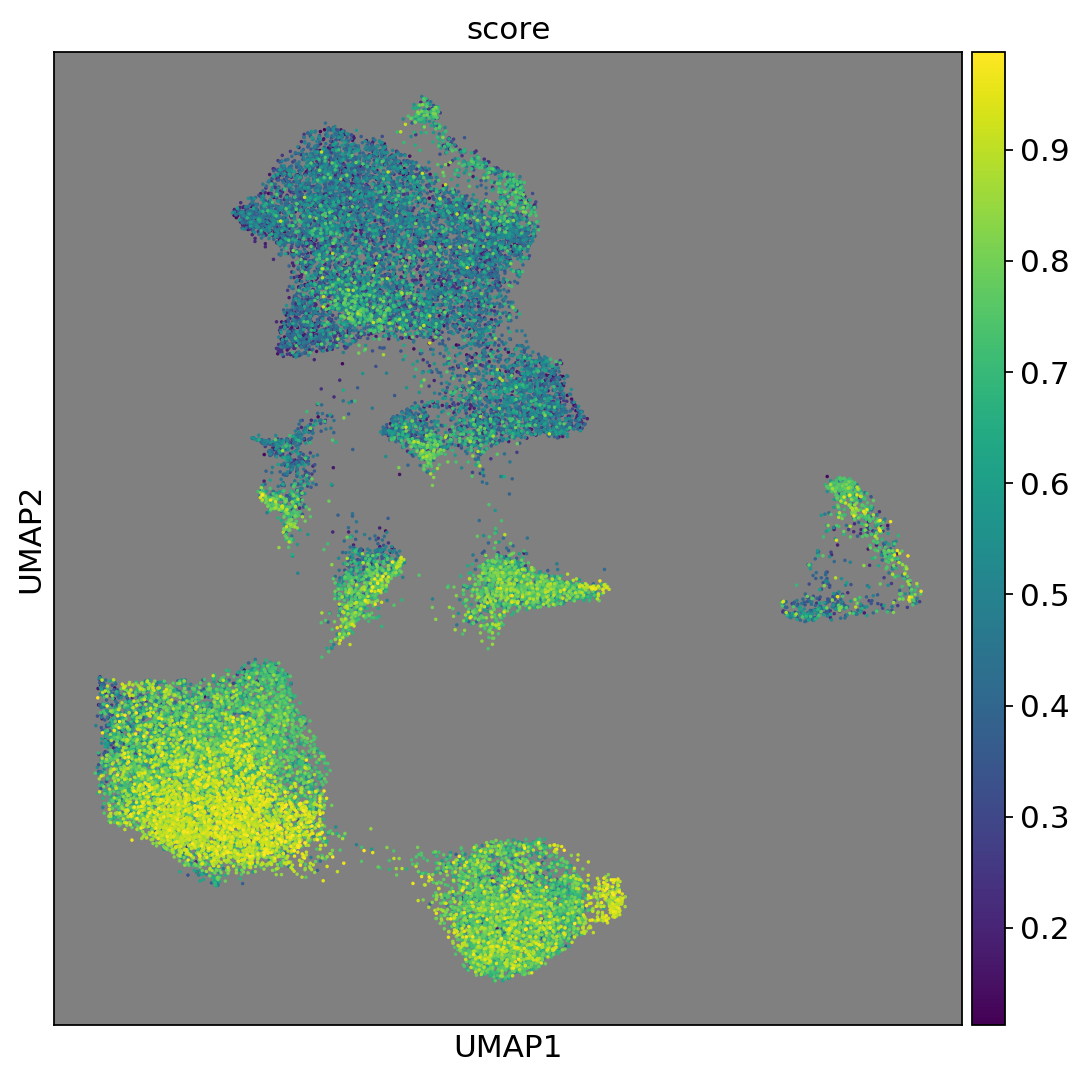

In [57]:
sc.settings.set_figure_params(dpi=80)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('gray')
sc.pl.umap(adata_keep,ax=ax, show=False, return_fig=False, size=10, color='score');

In [58]:
covars = adata_keep.obs[['batch', 'celltype1','celltype2','spatial_bc','X','Y','%Hepato','score']]

In [59]:
covars['Hep'] = covars['%Hepato'].values >= 0.5

/home/ghartoularos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [84]:
covars[covars['batch'] == '1'].index.values.shape

(12572,)

In [77]:
with open(prefix + "L20C1.cells.txt", 'r') as file:
    l20c1_cells = [i.strip() + '-1' for i in file.readlines()]

In [83]:
np.intersect1d(l20c1_cells, covars[covars['batch'] == '1'].index.values)

array(['L20C1_P1A01F.CTAGGTCTAGTGCAAT-1',
       'L20C1_P1A01F.CTCATACCTGCTACCT-1',
       'L20C1_P1A01F.GACGACACGCTCACTC-1', ...,
       'L20C1_P4H12F.TCCACTGGAGTGTCGC-1',
       'L20C1_P4H12F.TCCTCCACGTGGACTC-1',
       'L20C1_P4H12F.TTGGACGTGAGATAGT-1'], dtype=object)

**Update 20FEB20:** Derek asked for "smoother" scores (less binary looking?) for the continuous variable in the spatial differential expression analyses he's doing. The first line below was used originally, and then I made a new file with the new smoother scores. 

In [63]:
# covars.to_csv('/data/xyzeq/xyzeq/concatenated.deep/deep2/covars.with.proximity.scores.csv', header=False)
covars.to_csv(prefix + 'concatenated.deep/deep2/covars.with.smooth.proximity.scores.csv', header=False)